# Statistical tests for "Silicone: an open-source Python package for inferring missing emissions data for climate change research"
This notebook is where results that require exploration of the data outside of the silicone package were calculated. The results that go into this notebook were derived by running the script `scripts/compare_crunchers.py`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
CO2_results_orig = pd.read_csv("../input/CruncherComparisonLead_CO2.csv", index_col=0)
CH4_results_orig = pd.read_csv("../input/CruncherComparisonLead_CH4.csv", index_col=0)

## Calculating the difference between infilling with CO2 and CH4 emissions
We can't compare the values with CO2 or CH4 itself, as they are only found in one of the two datasets, so we start by removing them. 

In [3]:
to_drop = ["Emissions|CO2", "Emissions|CH4"]
CO2_results = CO2_results_orig.drop(to_drop, errors="ignore")
CH4_results = CH4_results_orig.drop(to_drop, errors="ignore")

We can now calculate the difference

In [4]:
difference_res = (CO2_results - CH4_results)
difference_res

,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,0.001082,0.003908,0.008356,0.006009
Emissions|CO,0.001044,0.021310,0.005379,-0.002127
Emissions|F-Gases,-0.005316,-0.004709,-0.006543,-0.011260
Emissions|HFC,-0.010724,0.011296,-0.017329,-0.018573
Emissions|N2O,0.032117,0.029422,0.051840,0.059061
Emissions|NH3,0.005295,0.032770,0.026440,0.001498
Emissions|NOx,-0.003443,-0.003901,0.000387,0.001834
Emissions|OC,0.002656,0.021998,0.017794,0.022770
Emissions|PFC,0.010144,0.035372,0.012306,0.008392
Emissions|SF6,0.005139,-0.001192,-0.001571,0.003733


We investigate these visually and using the Shapiro-Wilk test to check for normality.

([array([0., 3., 5., 3., 0., 0., 1., 0., 0., 0.]),
  array([0., 2., 3., 1., 1., 2., 3., 0., 0., 0.]),
  array([1., 1., 3., 3., 2., 1., 0., 0., 0., 1.]),
  array([2., 1., 5., 2., 0., 1., 0., 0., 0., 1.])],
 array([-0.01857339, -0.01080995, -0.00304651,  0.00471693,  0.01248037,
         0.02024382,  0.02800726,  0.0357707 ,  0.04353414,  0.05129758,
         0.05906102]),
 <a list of 4 Lists of Patches objects>)

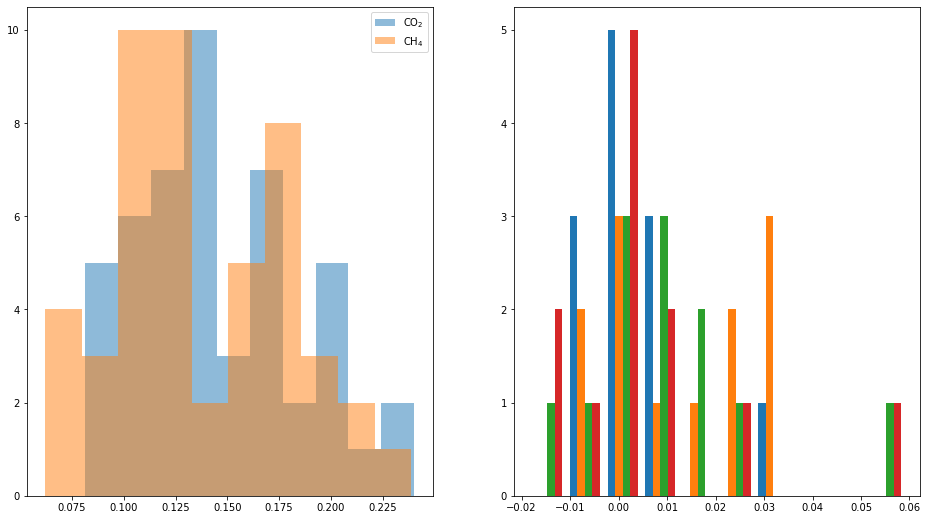

In [5]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(121)
plt.hist(CO2_results.values.ravel(), alpha = 0.5, label="CO$_2$")
plt.hist(CH4_results.values.ravel(), alpha = 0.5, label="CH$_4$")
ax.legend()
ax = plt.subplot(122)
plt.hist(difference_res.values)

In [6]:
for col in CO2_results:
    stat, pc = stats.shapiro(CO2_results[col])
    stat, pm = stats.shapiro(CH4_results[col])
    print("For {}, CO2 has p-value {} and CH4 has {}".format(col, pc, pm))
stat, pc = stats.shapiro(CO2_results.values)
stat, pm = stats.shapiro(CH4_results.values)
print("For all values together, CO2 has p-value {} and CH4 has {}".format(pc, pm))

For QuantileRollingWindows, CO2 has p-value 0.5874438285827637 and CH4 has 0.5447214841842651
For RMSClosest, CO2 has p-value 0.3771941661834717 and CH4 has 0.1458592712879181
For LinearInterpolation, CO2 has p-value 0.6368883848190308 and CH4 has 0.3085280656814575
For EqualQuantileWalk, CO2 has p-value 0.7375178337097168 and CH4 has 0.9932032823562622
For all values together, CO2 has p-value 0.09097322821617126 and CH4 has 0.3718063533306122


All values exceed 0.05, so it appears that we can safely assume a Gaussian spread for doing statistics. 

In [7]:
# Calculate the t-test statistics for each cruncher
stats.ttest_rel(CO2_results.values, CH4_results.values)

Ttest_relResult(statistic=array([1.02320263, 3.11892134, 1.93877008, 0.93077944]), pvalue=array([0.32818794, 0.00976877, 0.07860579, 0.37194494]))

In [8]:
# Calculate the t-test statistics for all data together
stats.ttest_rel(CO2_results.values.ravel(), CH4_results.values.ravel())

Ttest_relResult(statistic=3.4193737300660745, pvalue=0.0013067333626455874)

# Calculating the difference between crunchers
We can include the CH$_4$ and CO$_2$ results again now, as we are not doing pairwise comparison. 

In [9]:
all_results = CO2_results_orig.append(CH4_results_orig)
all_results

,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,0.129157,0.118940,0.176855,0.161039
Emissions|CH4,0.085871,0.072788,0.096929,0.093807
Emissions|CO,0.140090,0.133444,0.182223,0.175247
Emissions|F-Gases,0.106261,0.094665,0.125233,0.118164
Emissions|HFC,0.152433,0.140330,0.165032,0.159283
Emissions|N2O,0.110363,0.091487,0.136481,0.134480
Emissions|NH3,0.174929,0.151405,0.239547,0.240262
Emissions|NOx,0.103714,0.094937,0.131779,0.120640
Emissions|OC,0.144260,0.128828,0.196234,0.202308
Emissions|PFC,0.132374,0.100929,0.119947,0.162719


Test for normality:

In [10]:
for col in all_results:
    print(stats.shapiro(all_results[col]))

(0.9435780048370361, 0.163483127951622)
(0.9737557768821716, 0.7218422889709473)
(0.9457546472549438, 0.18416132032871246)
(0.9680128693580627, 0.5725182890892029)


In [11]:
stats.shapiro(all_results)

(0.9676622152328491, 0.012031701393425465)

The individual cruncher results are all fairly normal (although the aggregate is not, as they do not have the same average). We can now do pairwise comparisons of the crunchers: 

In [12]:
results_all = []
results_CO2 = []
results_CH4 = []
column_combo = combinations(all_results.columns, 2)
for col1, col2 in column_combo:
    results_all.append([col1, col2, stats.ttest_rel(all_results[col1], all_results[col2]).pvalue])
    results_CO2.append([col1, col2, stats.ttest_rel(CO2_results_orig[col1], CO2_results_orig[col2]).pvalue])
    results_CH4.append([col1, col2, stats.ttest_rel(CH4_results_orig[col1], CH4_results_orig[col2]).pvalue])

In [13]:
results_all

[['QuantileRollingWindows', 'RMSClosest', 3.052133012230844e-08],
 ['QuantileRollingWindows', 'LinearInterpolation', 1.548027528452534e-07],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 9.291247398054141e-08],
 ['RMSClosest', 'LinearInterpolation', 4.229397360535865e-11],
 ['RMSClosest', 'EqualQuantileWalk', 6.597777415431516e-09],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.6119262485421693]]

In [14]:
results_CH4

[['QuantileRollingWindows', 'RMSClosest', 0.00010381623682828899],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0002669872373789759],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.00050529920779666],
 ['RMSClosest', 'LinearInterpolation', 5.837249331609981e-06],
 ['RMSClosest', 'EqualQuantileWalk', 0.00013815528403625854],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.5171572129869282]]

In [15]:
results_CO2

[['QuantileRollingWindows', 'RMSClosest', 2.9589595165785068e-05],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0002751529198166419],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.00011145561087452433],
 ['RMSClosest', 'LinearInterpolation', 5.71229517722896e-06],
 ['RMSClosest', 'EqualQuantileWalk', 1.709964278032949e-05],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.9896697093945696]]

In [16]:
all_results.mean()

QuantileRollingWindows    0.129873
RMSClosest                0.107978
LinearInterpolation       0.156271
EqualQuantileWalk         0.157880
dtype: float64

We can see that there are statistically significantly different means between all the crunchers except LinearInterpolation and EQW for either lead gas or both together. 